# M2177.004300 Deep Learning Assignment #1<br> Part 1-1. Training MLP (Pytorch)

Copyright (C) Data Science & AI Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. Written by Jieun Byeon, September 2025

**For understanding of this work, please carefully look at given PDF file.**

Now, you're going to leave behind your implementations and instead migrate to one of popular deep learning frameworks, **PyTorch**. <br>
In this notebook, you will learn how to train MLPs for classifying images in the FashionMNIST dataset. <br>

**<font color=red> Do not clear the outputs </font>**

## 1. Load datasets
The FashionMNIST dataset will be downloaded automatically if it is not located in the *data* directory. <br>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pwd # 현재 경로 확인

'/content/drive/MyDrive/Assignment1'

In [ ]:
# Assighment1 경로로 이동
%cd /content/drive/MyDrive/Assignment1

/content/drive/MyDrive/Assignment1


In [ ]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import display, Image
from pathlib import Path
from PIL import Image as PILImage
import torch
from torch.utils.data import Dataset, random_split
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter

import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
g = torch.Generator()
g.manual_seed(seed)

# Config the matplotlib backend as plotting inline in IPython
# %matplotlib inline
# PLEASE Comment this line on submission

In [ ]:
# Define preprocessing: convert to tensor and normalize to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load dataset
full_train_dataset = torchvision.datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform
)

# Split training set into train (90%) and validation (10%)
train_size = int(0.9 * len(full_train_dataset))
valid_size = len(full_train_dataset) - train_size
train_dataset, valid_dataset = random_split(full_train_dataset, [train_size, valid_size], generator=g)

# Create DataLoaders
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Class names for Fashion-MNIST
fashion_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Check dataset sizes
print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(valid_dataset))
print("Test dataset size:", len(test_dataset))



Train dataset size: 54000
Validation dataset size: 6000
Test dataset size: 10000


### Visualize some samples

Batch shape: torch.Size([64, 1, 28, 28])
Single image shape: torch.Size([1, 28, 28])
Image size (HxW): 28 x 28


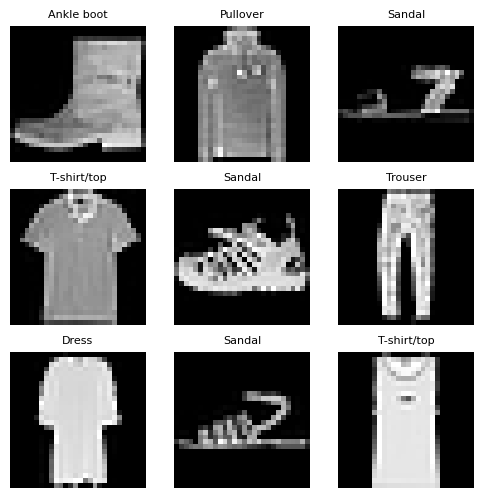

In [ ]:
# Get a batch of training data
images, labels = next(iter(train_loader))

# Check the shape of the entire batch
print("Batch shape:", images.shape)

# Check the shape of a single image
print("Single image shape:", images[0].shape)

# Check the height and width of a single image
print("Image size (HxW):", images[0].shape[1], "x", images[0].shape[2])

image_size = images[0].shape[1] # shape[1] == shape[2] for square images
num_classes = len(fashion_labels) # num of classes

# Plot first 9 images
fig, axes = plt.subplots(3, 3, figsize=(6,6))
for ax, img, lab in zip(axes.flat, images[:9], labels[:9]):
    ax.imshow(img.squeeze(), cmap="gray")
    ax.set_title(f"{fashion_labels[lab]}", fontsize=8)
    ax.axis("off")

plt.show()


## Train a Multi-Layer Perceptron (MLP)

Now, We're first going to train a multi-layer-perceptron using stochastic gradient descent (SGD).

### 1. Define Naive Linear model
- model should inherit nn.Module
- implement feed forward by overriding **forward** method of nn.Module

In [ ]:
class NaiveLinear(nn.Module):

    def __init__(self, in_features, out_features):
        super(NaiveLinear, self).__init__()
        self.weight = Parameter(torch.Tensor(in_features, out_features))
        self.bias = Parameter(torch.Tensor(out_features))
        torch.nn.init.uniform_(self.weight, -1.0, 1.0)
        torch.nn.init.zeros_(self.bias)

    def forward(self, input):
        return torch.matmul(input, self.weight) + self.bias

In [ ]:
class Model(nn.Module):

    def __init__(self, in_features, nn_hidden, num_labels):
        super(Model, self).__init__()
        self.fc1 = NaiveLinear(in_features, nn_hidden)
        self.fc2 = NaiveLinear(nn_hidden, nn_hidden)
        self.fc3 = NaiveLinear(nn_hidden, num_labels)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc3(x)
        return x

In [ ]:
nn_hidden = 1024

model = Model(image_size*image_size, nn_hidden, num_classes)

# move model to GPU
if torch.cuda.is_available():
    print("CUDA is available! Training on GPU ...")
    device = 'cuda:0'
    model.to(device)
else :
    device = 'cpu'
    print("Training on CPU ...")

# print model, initialized weight, grad buffer
print(model)
print(model.fc1.weight.data)
print(model.fc1.bias.grad)

CUDA is available! Training on GPU ...
Model(
  (fc1): NaiveLinear()
  (fc2): NaiveLinear()
  (fc3): NaiveLinear()
)
tensor([[ 0.4413, -0.5736,  0.9909,  ...,  0.6649, -0.3212,  0.3001],
        [-0.4371, -0.4673,  0.4923,  ...,  0.3413, -0.2329, -0.1527],
        [ 0.3689,  0.0298, -0.5279,  ...,  0.7694,  0.1125,  0.8665],
        ...,
        [ 0.5604,  0.4894, -0.3158,  ..., -0.3532,  0.4556, -0.7708],
        [ 0.1610, -0.6990,  0.6578,  ..., -0.1431,  0.3356,  0.4335],
        [-0.9639,  0.6430, -0.6478,  ...,  0.0578, -0.6042, -0.8315]],
       device='cuda:0')
None


Now, define loss function and optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=model.parameters(), lr=0.005)

Let's run this computation and iterate:

In [ ]:
epochs = 20

def accuracy(logits, labels):
    preds = torch.argmax(logits, dim=1)
    return (preds == labels).float().mean().item() * 100

def train(model, device, train_loader, optimizer, epoch, criterion):
    model.train()
    loss_total, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        images = images.view(images.size(0), -1)  # flatten

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        # accumulate stats
        loss_total += loss.item() * images.size(0) #batch size
        correct += (torch.argmax(logits, dim=1) == labels).sum().item()
        total += labels.size(0)

    avg_loss = loss_total / total
    acc = 100.0 * correct / total
    print(f"Train Epoch: {epoch}\tLoss: {avg_loss:.6f}\tAccuracy: {acc:.2f}")

@torch.no_grad()
def evaluate(model, device, loader, desc="eval"):
    model.eval()
    correct, total = 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        images = images.view(images.size(0), -1)
        logits = model(images)

        correct += (torch.argmax(logits, dim=1) == labels).sum().item()
        total += labels.size(0)

    acc = 100.0 * correct / total
    print(f"{desc} Accuracy: {acc:.2f}")


In [ ]:
for epoch in range(epochs):
    train(model, device, train_loader, optimizer, epoch+1, criterion)
    print('-------- validation --------')
    evaluate(model, device, valid_loader, desc="valid" )


print('-------- test ---------')
evaluate(model, device, test_loader, desc="test")


# save model
os.makedirs('./model_checkpoints', exist_ok=True)
torch.save(model.state_dict(), './model_checkpoints/MLP_naive_model_final.pt')

KeyboardInterrupt: 

So far, you have built the model in a naive way. However, PyTorch provides a linear module named nn.Linear for your convenience.
### 2. Use nn.Linear

From now on, build the same model as above using layers module.

You can also build model using nn.Sequential()

In [ ]:
model = nn.Sequential(
            # neural network using nn.Linear
            nn.Linear(image_size * image_size, nn_hidden),
            nn.ReLU(),
            nn.Linear(nn_hidden, num_classes)
            )

model.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimiz`er, gamma=0.99)

In [ ]:
for epoch in range(epochs):
    train(model, device, train_loader, optimizer, epoch+1, criterion)
    print('-------- validation --------')
    evaluate(model, device, valid_loader, desc="valid")


print('-------- test ---------')
evaluate(model, device, test_loader, desc="test")


# save model
torch.save(model.state_dict(), './model_checkpoints/MLP_linear_model_final.pt')
print('layer_model saved')

Train Epoch: 1	Loss: 0.765163	Accuracy: 75.31
-------- validation --------
valid Accuracy: 79.85
Train Epoch: 2	Loss: 0.512451	Accuracy: 82.11
-------- validation --------
valid Accuracy: 82.35
Train Epoch: 3	Loss: 0.464050	Accuracy: 83.59
-------- validation --------
valid Accuracy: 83.23
Train Epoch: 4	Loss: 0.436698	Accuracy: 84.57
-------- validation --------
valid Accuracy: 83.90
Train Epoch: 5	Loss: 0.417376	Accuracy: 85.32
-------- validation --------
valid Accuracy: 84.48
Train Epoch: 6	Loss: 0.402272	Accuracy: 85.82
-------- validation --------
valid Accuracy: 84.88
Train Epoch: 7	Loss: 0.389757	Accuracy: 86.20
-------- validation --------
valid Accuracy: 85.20
Train Epoch: 8	Loss: 0.378999	Accuracy: 86.59
-------- validation --------
valid Accuracy: 85.53
Train Epoch: 9	Loss: 0.369581	Accuracy: 86.94
-------- validation --------
valid Accuracy: 85.88
Train Epoch: 10	Loss: 0.361203	Accuracy: 87.25
-------- validation --------
valid Accuracy: 86.28
Train Epoch: 11	Loss: 0.35361

---
Problem 1
-------

**Describe below** why there is a difference in an accuracy between the model using nn.Linear and the model which is built in a naive way. **explain simply**  
You can refer to PyTorch documentation(https://pytorch.org/docs/stable/index.html) to check tjhe implementation of nn.Linear()

---

nn.Linear에서는 U(-sqrt(k), sqrt(k))로 초기화해 역전파가 잘 이루어지는 분산으로 설정한다.

반면 Naive model은 U(-1,1)로 초기화한다. 초기값이 좋지 않아 정확도가 낮아질 수 있다.

---
Problem 2
-------

Try to get the best performance you can using a multi-layer model! (It doesn't matter whether you implement it in a naive way or using layer module. **HOWEVER, you CANNOT use other type of layers such as conv.**)

You may use techniques below.

1. Experiment with different hyperparameters: epochs, learning rate, hidden dimension etc.
2. We used a fixed learning rate epsilon for gradient descent. Implement an annealing schedule for the gradient descent learning rate ([more info](http://cs231n.github.io/neural-networks-3/#anneal)). *Hint*. Try using `torch.optim.lr_scheduler.ExponentialLR()`.    
3. Extend the network to multiple hidden layers. Experiment with the layer sizes. Adding another hidden layer means you will need to adjust the code.
4. Introduce and tune regularization method (e.g. L2 regularization) for your model. Remeber that L2 amounts to adding a penalty on the norm of the weights to the loss. The right amount of regularization should imporve your validation / test accuracy.

**Evaluation**: You will get full credit if your best test accuracy <font color=red> >= 86\% </font>

**Caution**: Please save your best model using the following command:
```python
torch.save(model.state_dict(), './model_checkpoints/MLP_best_model_final.pt')

In [ ]:
# save model
save_dir = "./model_checkpoints"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "MLP_best_model_final.pt")
torch.save(model.state_dict(), save_path)

print(f"Model saved at {save_path}")

Model saved at ./model_checkpoints/MLP_best_model_final.pt


### Describe what you did for MLP_best_model here

epoch 20회로 늘리기

learning rate 0.01로 두배로 만들기

(레이어쌓기, learging rate조절 감마 도입하기는 큰효과를 보지 못함)